In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
import scipy as sp

from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_predict
from sklearn.externals import joblib

import lightgbm as lgb
import xgboost as xgb

import re

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

/home/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Mean Target Encodings Declaration

In [4]:
class MeanTargetEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_columns, target_name, alpha=100):
        self.cat_columns = cat_columns
        self.target_name = target_name
        self.mean_encodings = {}
        self.alpha = alpha
        
    def fit(self, X, y=None):
        self.global_mean = X[self.target_name].mean()
        
        def smoothing(x):
            return (x.mean() * len(x) + self.global_mean * self.alpha) / (len(x) + self.alpha)    

        for col in self.cat_columns:
            self.mean_encodings[col] = X.groupby(col)[self.target_name].apply(smoothing)
            
    def predict(self, X):
        X_new = np.zeros(shape=(len(X), len(self.cat_columns)))

        for index, col in enumerate(self.cat_columns):    
            X_new[:, index] = X.loc[:, col].map(self.mean_encodings[col]).fillna(self.global_mean).values

        return X_new

In [5]:
class XGBoostLeaves(BaseEstimator, ClassifierMixin):
    params = {
        'objective': 'binary:logistic',
        'eta': .1,
        'max_depth': 4,
        'silent': 1,
        'nthread': 4,
        'seed': SEED
    }
    
    def __init__(self, num_leaves):
        self.num_leaves = num_leaves
        
    def fit(self, X, y):
        dtrain = xgb.DMatrix(X, y)
        self.model = xgb.train(self.params, dtrain, self.num_leaves)
        
    def predict(self, X):
        return self.model.predict(xgb.DMatrix(X), pred_leaf=True)

## Paths

In [6]:
TRAIN_PATH     = os.path.join(basepath, 'data/processed/train_text.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/test_text.feather')
INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission34.feather')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev8/tr.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev8/val.feather')
# INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission34_val.feather')
# OOF_PATH       = os.path.join(basepath, 'oof_preds/submission34_oof.pkl')

In [7]:
%%time

train  = pd.read_feather(f'{TRAIN_PATH}')
test   = pd.read_feather(f'{TEST_PATH}')

CPU times: user 615 ms, sys: 422 ms, total: 1.04 s
Wall time: 4.73 s


In [8]:
ntrain = len(train)

## Data Subset

In [9]:
train = train.loc[train.communication_type.isin(['Upcoming Events',
                                                 'Newsletter',
                                                 'Hackathon',
                                                 'Corporate'
                                                ])]
ntrain = len(train)

## Subject line features

In [9]:
%%time

# first keyword of the subject
train.loc[:, 'first_keyword'] = train.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[0])).str.replace(r'September|July|October|November|December', 'month')
test.loc[:, 'first_keyword']  = test.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[0])).str.replace(r'September|July|October|November|December', 'month')

# second keyword of the subject
train.loc[:, 'second_keyword'] = train.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[1])).str.replace(r'September|July|October|November|December', 'month')
test.loc[:, 'second_keyword']  = test.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[1])).str.replace(r'September|July|October|November|December', 'month')

# third keyword of the subject
train.loc[:, 'third_keyword'] = train.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[2])).str.replace(r'September|July|October|November|December', 'month')
test.loc[:, 'third_keyword']  = test.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[2])).str.replace(r'September|July|October|November|December', 'month')

CPU times: user 20.5 s, sys: 367 ms, total: 20.8 s
Wall time: 20.9 s


## Feature Engineering

### Mean Target Encodings

#### User Click MTE

In [10]:
%%time

### TRAIN ####
mte_click         = MeanTargetEncoding(['user_id'], target_name='is_click')
mte_click_encoded = cross_val_predict(mte_click, train, y=train.is_click, cv=5, n_jobs=1)

user_click_mte = pd.DataFrame(mte_click_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

### TEST ###
mte_click.fit(train, train.is_click)
mte_click_test_encoded = mte_click.predict(test)


user_click_test =  pd.DataFrame(mte_click_test_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

# joblib.dump(user_click_mte, '../data/interim/user_click_mte.pkl')
# joblib.dump(user_click_test, '../data/interim/user_click_test.pkl')

# del user_click_mte, user_click_test, mte_click_encoded, mte_click_test_encoded, mte_click
# gc.collect()

CPU times: user 1min 33s, sys: 1.34 s, total: 1min 35s
Wall time: 1min 34s


#### User Open MTE

In [11]:
%%time

mte_open         = MeanTargetEncoding(['user_id'], target_name='is_open')
mte_open_encoded = cross_val_predict(mte_open, train, y=train.is_open, cv=5, n_jobs=1)

user_open_mte = pd.DataFrame(mte_open_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

mte_open.fit(train, train.is_open)
mte_open_test_encoded = mte_open.predict(test)

user_open_test =  pd.DataFrame(mte_open_test_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

# joblib.dump(user_open_mte, '../data/interim/user_open_mte.pkl')
# joblib.dump(user_open_test, '../data/interim/user_open_test.pkl')

# del user_open_mte, user_open_test, mte_open_encoded, mte_open_test_encoded, mte_open
# gc.collect();

CPU times: user 1min 34s, sys: 1.16 s, total: 1min 36s
Wall time: 1min 35s


#### Communication Type Click MTE

In [12]:
%%time

comm_type_click         = MeanTargetEncoding(['communication_type'], target_name='is_click')
comm_type_click_encoded = cross_val_predict(comm_type_click, train, y=train.is_click, cv=5, n_jobs=1)

comm_type_click_mte = pd.DataFrame(comm_type_click_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['comm_type']],
            index=train.index.values
            )

comm_type_click.fit(train, train.is_click)
comm_type_click_test_encoded = comm_type_click.predict(test)

comm_type_click_test = pd.DataFrame(comm_type_click_test_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['comm_type']],
            index=test.index.values
            )

# joblib.dump(comm_type_click_mte, '../data/interim/comm_type_click_mte.pkl')
# joblib.dump(comm_type_click_test, '../data/interim/comm_type_click_test.pkl')

# del comm_type_click_mte, comm_type_click_test, comm_type_click_encoded, comm_type_click_test_encoded
# gc.collect();

CPU times: user 2.03 s, sys: 96.4 ms, total: 2.13 s
Wall time: 2.12 s


#### User Communication Click MTE

In [13]:
%%time

train.loc[:, 'user_comm']    = train.user_id.astype(np.str) + '_' + train.communication_type.astype(np.str)
user_comm_type_click         = MeanTargetEncoding(['user_comm'], target_name='is_click')
user_comm_type_click_encoded = cross_val_predict(user_comm_type_click, train, y=train.is_click, cv=5, n_jobs=1)

user_comm_type_click_mte = pd.DataFrame(user_comm_type_click_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_comm']],
            index=train.index.values
            )


test.loc[:, 'user_comm']    = test.user_id.astype(np.str) + '_' + test.communication_type.astype(np.str)
user_comm_type_click.fit(train, train.is_click)
user_comm_type_click_test_encoded = user_comm_type_click.predict(test)


user_comm_type_click_test = pd.DataFrame(user_comm_type_click_test_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_comm']],
            index=test.index.values
            )

# joblib.dump(user_comm_type_click_mte, '../data/interim/user_comm_type_click_mte.pkl')
# joblib.dump(user_comm_type_click_test, '../data/interim/user_comm_type_click_test.pkl')

# del user_comm_type_click_mte, user_comm_type_click, 
# del user_comm_type_click_encoded, user_comm_type_click_test_encoded, user_comm_type_click_test
# gc.collect();

CPU times: user 4min 23s, sys: 3.39 s, total: 4min 27s
Wall time: 4min 24s


#### Load Saved Pickles

In [22]:
%%time

user_click_mte  = joblib.load('../data/interim/user_click_mte.pkl')
user_click_test = joblib.load('../data/interim/user_click_test.pkl')

user_open_mte   = joblib.load('../data/interim/user_open_mte.pkl')
user_open_test  = joblib.load('../data/interim/user_open_test.pkl')

comm_type_click_mte   = joblib.load('../data/interim/comm_type_click_mte.pkl')
comm_type_click_test  = joblib.load('../data/interim/comm_type_click_test.pkl')

user_comm_type_click_mte   = joblib.load('../data/interim/user_comm_type_click_mte.pkl')
user_comm_type_click_test  = joblib.load('../data/interim/user_comm_type_click_test.pkl')

CPU times: user 405 ms, sys: 32.2 ms, total: 438 ms
Wall time: 439 ms


In [14]:
train = pd.concat((train, user_click_mte, user_open_mte, comm_type_click_mte, user_comm_type_click_mte), axis=1)
test  = pd.concat((test, user_click_test, user_open_test, comm_type_click_test, user_comm_type_click_test), axis=1)

# del user_click_mte, user_click_test, user_open_mte, user_open_test
# del user_comm_type_click_mte, user_comm_type_click_test, comm_type_click_mte, comm_type_click_test
# gc.collect();

In [15]:
%%time

user_id_stats = train.groupby('user_id').agg({'comm_type_click_mte_mean': [np.mean, np.std, np.max, np.min, np.median]})
user_id_stats.columns = ['comm_type_click_mean', 'comm_type_click_std',
                         'comm_type_click_max', 'comm_type_click_min',
                         'comm_type_click_median'
                        ]

train = train.merge(user_id_stats.reset_index(),
            on='user_id',
            how='left'
           ).fillna(-1)

test  = test.merge(user_id_stats.reset_index(),
            on='user_id',
            how='left'
           ).fillna(-1)

CPU times: user 4.79 s, sys: 611 ms, total: 5.4 s
Wall time: 5.42 s


In [16]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

### Other Features

In [17]:
%%time

def get_most_sent_type(rows):
    return rows.communication_type.value_counts().index.values[0]

def get_avg_diff_send_date(x):
    if len(x) > 1:
        return x.sort_values(by='send_date').loc[:, 'send_date'].diff().dt.days.mean()
    else:
        return -1
    
def get_num_hackathon_emails(row):
    return len(row.loc[row.communication_type == 'Hackathon'])

# datetime features
traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

# number of hackathon related emails sent to user before
num_hackathon_emails                     = traintest.groupby('user_id').apply(get_num_hackathon_emails)
traintest.loc[:, 'num_hackathon_emails'] = traintest.user_id.map(num_hackathon_emails)

# communication type of the email
traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]

# number of different emails sent to user
num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

# number of different email types sent to user
num_diff_email_types                     = traintest.groupby('user_id')['communication_type'].nunique()
traintest.loc[:, 'num_diff_email_types'] = traintest.user_id.map(num_diff_email_types)

# most sent communication type to user
most_sent_type = traintest.groupby('user_id').apply(get_most_sent_type)
traintest.loc[:, 'most_sent_type'] = traintest.user_id.map(most_sent_type)

# at how many different hours did we send an email to user ?
diff_hour = traintest.groupby('user_id').apply(lambda x: x.send_date.dt.hour.nunique())
traintest.loc[:, 'diff_hour'] = traintest.user_id.map(diff_hour)

# average of difference between last send date and current send date
avg_diff_send_date = traintest.groupby('user_id').apply(get_avg_diff_send_date)
traintest.loc[:, 'avg_diff_send_date']  = traintest.user_id.map(avg_diff_send_date)

# age of the user determined by most recent 
user_age = traintest.groupby('user_id').apply(lambda x: (x['send_date'].max() - x['send_date'].min()).days)
traintest.loc[:, 'user_age'] = traintest.user_id.map(user_age)

CPU times: user 10min 45s, sys: 5.81 s, total: 10min 50s
Wall time: 10min 50s


### Save interim state

In [18]:
%%time

traintest.index = np.arange(len(traintest))
traintest.to_feather(f'{INTERIM_PATH}')

CPU times: user 1.64 s, sys: 509 ms, total: 2.15 s
Wall time: 6.57 s


### Load from interim state

In [9]:
%%time

traintest = pd.read_feather(f'{INTERIM_PATH}')

CPU times: user 210 ms, sys: 95.6 ms, total: 306 ms
Wall time: 305 ms


### Subject Line Based Features

In [19]:
%%time

# number of digits in the subject line.
digit_pattern      = re.compile(r'\d+')
traintest.loc[:, 'subject_num_digits'] = traintest.subject.map(lambda x: len(re.findall(digit_pattern, x)))

# whether subject line has punctuation or not.
punctuation_pattern = re.compile(r'[!.?\-",]+')
traintest.loc[:, 'subject_has_punctuation'] = traintest.subject.map(lambda x: int(len(re.findall(punctuation_pattern, x)) > 0))

# interaction between open rate and click rate.
traintest.loc[:, 'click_to_open']      = traintest.loc[:, 'user_id_click_mte_mean'] / traintest.loc[:, 'user_id_open_mte_mean']

# Number of keywords in subject.
traintest.loc[:, 'num_keywords']       = traintest.subject.map(lambda x: len(x.split(' ')))

# Number of short keywords in subject.
traintest.loc[:, 'num_short_keywords'] = traintest.subject.map(lambda x: len(list(filter(lambda x: len(x) > 4, x.split()))))

# Ratio of short to total keywords.
traintest.loc[:, 'ratio_short_total']  = traintest.num_short_keywords / traintest.num_keywords

# Total number of characters in the subject.
traintest.loc[:, 'num_characters']     = traintest.subject.map(lambda x: len(x))

# Number of times first keyword was used in the past
traintest.loc[:, 'first_keyword_count'] = traintest.groupby('first_keyword')['first_keyword'].transform(lambda x: len(x))

# Number of times second keyword was used in the past
traintest.loc[:, 'second_keyword_count'] = traintest.groupby('second_keyword')['second_keyword'].transform(lambda x: len(x))

# Number of times third keyword was used in the past
traintest.loc[:, 'third_keyword_count'] = traintest.groupby('third_keyword')['third_keyword'].transform(lambda x: len(x))

# Label Encode First Keyword
traintest.loc[:, 'first_keyword'] = pd.factorize(traintest.first_keyword)[0]

# Label Encode Second Keyword
traintest.loc[:, 'second_keyword'] = pd.factorize(traintest.second_keyword)[0]

# Label Encode Third Keyword
traintest.loc[:, 'third_keyword'] = pd.factorize(traintest.third_keyword)[0]

CPU times: user 31.7 s, sys: 4.01 s, total: 35.7 s
Wall time: 35.8 s


### Additional Features

In [20]:
%%time

# Bag of communication types
bag_comm_types = traintest.groupby(['user_id']).agg({'communication_type': lambda x: '_'.join(sorted(list(map(np.str, x.unique()))))})['communication_type']
traintest.loc[:, 'bag_of_comm_type'] = traintest.user_id.map(bag_comm_types)
traintest.loc[:, 'bag_of_comm_type'] = pd.factorize(traintest.loc[:, 'bag_of_comm_type'])[0]

CPU times: user 17.9 s, sys: 674 ms, total: 18.5 s
Wall time: 18.4 s


** Feature Names **

In [21]:
FEATURES = ['communication_type', 
            'send_day', 
            'send_hour', 
            'send_weekday',
            'total_links', 
            'no_of_internal_links', 
            'no_of_images', 
            'no_of_sections',
            'num_emails_sent', 
            'num_diff_email_types', 
            'most_sent_type', 
            'diff_hour', 
            'avg_diff_send_date',
            'user_id_click_mte_mean', 
            'user_id_open_mte_mean',
            'user_age', 
            'subject_num_digits', 
            'subject_has_punctuation',
            'click_to_open', 
            'num_keywords', 
            'num_short_keywords',
            'ratio_short_total', 
            'num_characters',
            'first_keyword_count', 
            'second_keyword_count', 
            'third_keyword_count',
            'comm_type_click_mte_mean',
            'comm_type_click_mean', 
            'comm_type_click_std',
            'comm_type_click_max', 
            'comm_type_click_min',
            'comm_type_click_median',
            'first_keyword', 
            'second_keyword',
            'third_keyword',
            'num_hackathon_emails',
            'bag_of_comm_type'
           ]

In [22]:
traintest.loc[:, FEATURES].isnull().sum()

communication_type          0
send_day                    0
send_hour                   0
send_weekday                0
total_links                 0
no_of_internal_links        0
no_of_images                0
no_of_sections              0
num_emails_sent             0
num_diff_email_types        0
most_sent_type              0
diff_hour                   0
avg_diff_send_date          0
user_id_click_mte_mean      0
user_id_open_mte_mean       0
user_age                    0
subject_num_digits          0
subject_has_punctuation     0
click_to_open               0
num_keywords                0
num_short_keywords          0
ratio_short_total           0
num_characters              0
first_keyword_count         0
second_keyword_count        0
third_keyword_count         0
comm_type_click_mte_mean    0
comm_type_click_mean        0
comm_type_click_std         0
comm_type_click_max         0
comm_type_click_min         0
comm_type_click_median      0
first_keyword               0
second_key

## Higher Order Interactions

### is_click

In [23]:
%%time

num_leaves = 20

train  = traintest.iloc[:ntrain].loc[:, FEATURES]
target = traintest.iloc[:ntrain]['is_click'].values
test   = traintest.iloc[ntrain:].loc[:, FEATURES]

xgbl = XGBoostLeaves(num_leaves=num_leaves)
xgbl_encoded = cross_val_predict(xgbl, train, y=target, cv=5, n_jobs=1)
xgbl_leaves  = pd.DataFrame(xgbl_encoded,
                            columns=['leaf_%s'%i for i in range(num_leaves)],
                            index=train.index.values
                           )

xgbl.fit(train, target)
xgbl_test_encoded = xgbl.predict(test)

xgbl_leaves_test = pd.DataFrame(xgbl_test_encoded, 
                   columns=['leaf_%s'%i for i in range(num_leaves)],
                   index=test.index.values
                   )


train = pd.concat((train, xgbl_leaves), axis=1)
test  = pd.concat((test, xgbl_leaves_test), axis=1)

# update feature list
FEATURES = FEATURES + list(xgbl_leaves.columns)

CPU times: user 7min 59s, sys: 5.42 s, total: 8min 4s
Wall time: 2min 17s


In [24]:
X_trn = train.loc[:, FEATURES]
y_trn = target

X_val = test.loc[:, FEATURES]
y_val = traintest.iloc[ntrain:]['is_click'].values

print(X_trn.shape, X_val.shape)

# del traintest
# gc.collect();

(1023191, 57) (773858, 57)


`(845444, 57) (50481, 57)`

`(458388, 57) (78941, 57)`

## Validation

In [33]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'nthread': 4
}


ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
leval  = lgb.Dataset(X_val, y_val, feature_name=FEATURES)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round       = 1000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.72065	eval's auc: 0.710677
[40]	train's auc: 0.739848	eval's auc: 0.732617
[60]	train's auc: 0.753387	eval's auc: 0.721665
[80]	train's auc: 0.763053	eval's auc: 0.706575
[100]	train's auc: 0.770804	eval's auc: 0.705988
[120]	train's auc: 0.776913	eval's auc: 0.7031
[140]	train's auc: 0.781403	eval's auc: 0.700379
Early stopping, best iteration is:
[46]	train's auc: 0.743577	eval's auc: 0.736325


```
[126]	train's auc: 0.746685	eval's auc: 0.693726
```

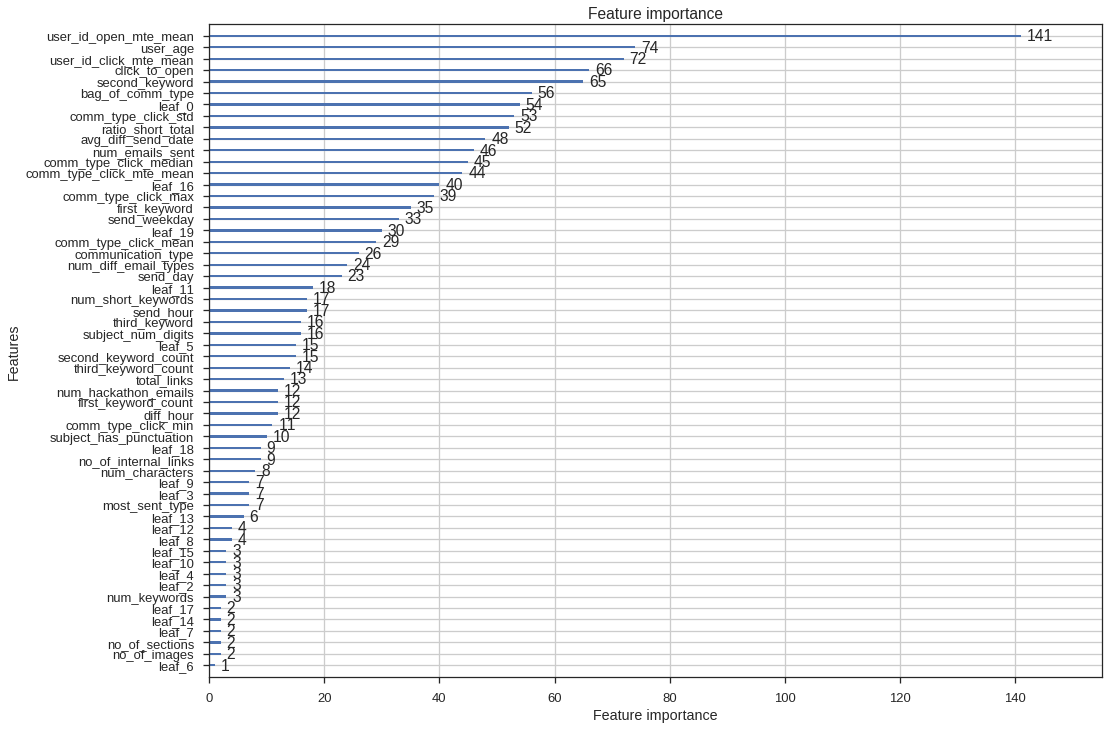

In [34]:
fig, ax = plt.subplots(1, figsize=(16, 12))
lgb.plot_importance(m, ax=ax);

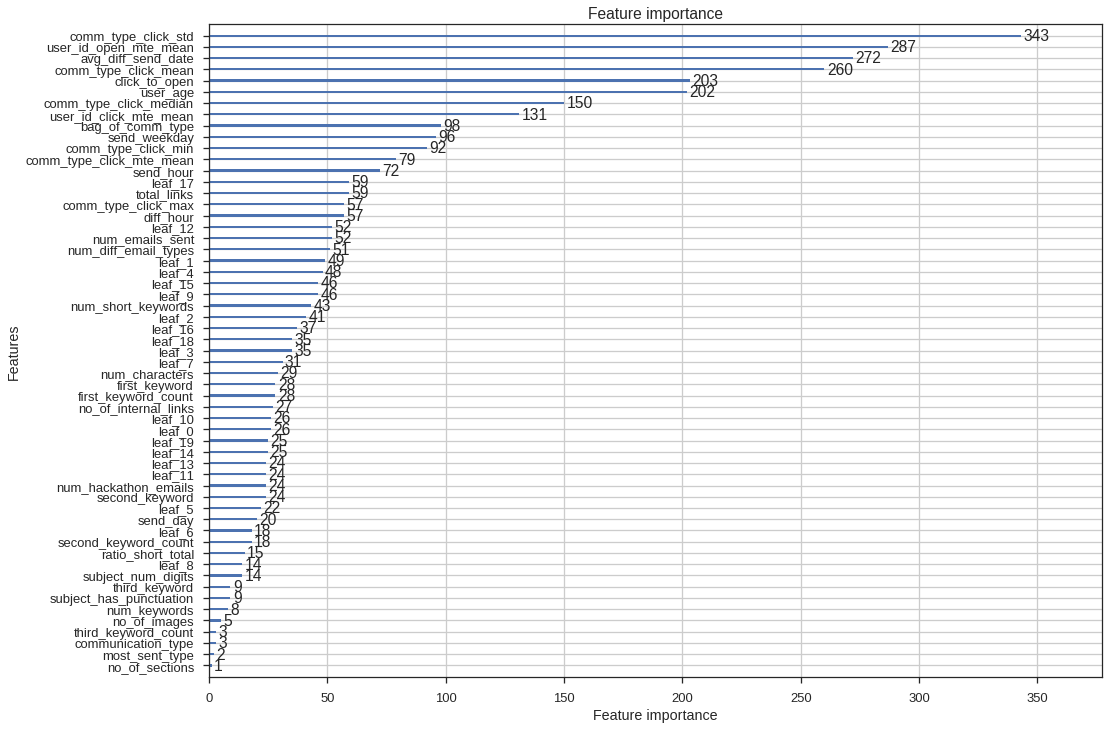

In [20]:
fig, ax = plt.subplots(1, figsize=(16, 12))
lgb.plot_importance(m, ax=ax);

In [23]:
# oof preds
val_preds = m.predict(X_val, num_iteration=m.best_iteration)
joblib.dump(val_preds, f'{OOF_PATH}')
joblib.dump(y_val, '../oof_preds/holdout_target.pkl')

['../oof_preds/holdout_target.pkl']

## Full Training

In [27]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': (.1 / 1.1),
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'nthread': 4
}

ltrain          = lgb.Dataset(X_trn, y_trn)
num_boost_round = int(46 * 1.1)

m = lgb.train(params, 
              ltrain, 
              num_boost_round)

preds = m.predict(X_val)

## Submission

In [28]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission34.csv', index=False)